In [1]:
# ============================================
# Logistic Regression — Step 1: Load preprocessing
# ============================================

%run "./02_preprocessing.ipynb"

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nClass distribution:\n", y_train.value_counts(normalize=True))


Initial shape: (15200, 15)
Exact duplicate rows: 192
Duplicate faculty_id: 8


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,promotion_opportunities,publications_last_3_years,student_evaluation_avg,left_institution
0,10000,Associate Professor,Tenure-Track,17,67410.138471,2,-2604.167089,Technical Institute,23,4,3,6,4,2.971100,0
1,10001,Full Professor,Non-Tenure,6,65578.523052,1,5601.080853,Technical Institute,8,6,6,6,6,3.681743,0
2,10002,Lecturer,Tenured,22,70730.493594,1,65860.624649,Technical Institute,11,9,1,7,9,1.002227,1
3,10003,Associate Professor,Tenured,0,59283.503256,4,41557.812521,Technical Institute,22,5,7,9,4,2.420985,0
4,10004,Associate Professor,Tenure-Track,26,66641.452922,5,26096.583217,Liberal Arts College,49,9,5,5,9,3.261318,0


Train shape: (12006, 13)
Test shape: (3002, 13)

Train target distribution:
left_institution
0    0.760287
1    0.239713
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'department_size', 'admin_support', 'work_life_balance', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg']
Preprocessor fitted successfully!
Processed shape: (12006, 34)
X_train shape: (12006, 13)
X_test shape: (3002, 13)

Class distribution:
 left_institution
0    0.760287
1    0.239713
Name: proportion, dtype: float64


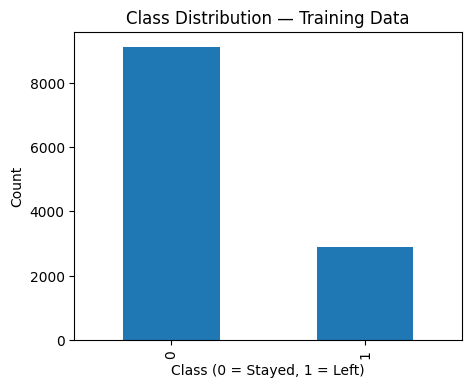

In [2]:
plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution — Training Data")
plt.xlabel("Class (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()


In [3]:
# ============================================
# Logistic Regression — Baseline Model
# ============================================

log_reg = Pipeline([
    ("preprocess", preprocessor),
    ("lr", LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("Baseline Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Baseline AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Baseline Logistic Regression Accuracy: 0.880413057961359
Baseline AUC: 0.8864674923864301

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      2283
           1       0.81      0.66      0.72       719

    accuracy                           0.88      3002
   macro avg       0.85      0.80      0.82      3002
weighted avg       0.88      0.88      0.88      3002



In [4]:
# ============================================
# Logistic Regression — Weighted Model
# ============================================

log_reg_weighted = Pipeline([
    ("preprocess", preprocessor),
    ("lr", LogisticRegression(
        class_weight='balanced',
        max_iter=500
    ))
])

log_reg_weighted.fit(X_train, y_train)

y_pred_lr_w = log_reg_weighted.predict(X_test)
y_prob_lr_w = log_reg_weighted.predict_proba(X_test)[:, 1]

print("Weighted Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr_w))
print("Weighted AUC:", roc_auc_score(y_test, y_prob_lr_w))


Weighted Logistic Regression Accuracy: 0.7994670219853431
Weighted AUC: 0.886021552540791


In [5]:
# ============================================
# Logistic Regression — Regularization Tuning
# ============================================

from sklearn.model_selection import GridSearchCV

param_grid = {
    "lr__C": [0.01, 0.1, 1, 10, 50],
    "lr__penalty": ["l2"]
}

log_reg_tuned = Pipeline([
    ("preprocess", preprocessor),
    ("lr", LogisticRegression(
        class_weight='balanced',
        solver="lbfgs",
        max_iter=500
    ))
])

grid_lr = GridSearchCV(
    estimator=log_reg_tuned,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best Params:", grid_lr.best_params_)
print("Best Cross-Validated AUC:", grid_lr.best_score_)


Best Params: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best Cross-Validated AUC: 0.8758256351204388


Final Logistic Regression Accuracy: 0.796469020652898
Final AUC: 0.8866027364379762

Final Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.85      2283
           1       0.55      0.86      0.67       719

    accuracy                           0.80      3002
   macro avg       0.75      0.82      0.76      3002
weighted avg       0.85      0.80      0.81      3002



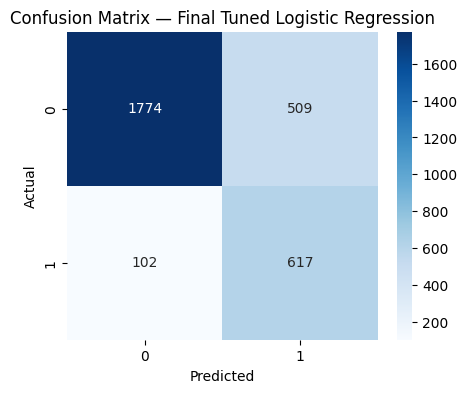

In [6]:
best_lr = grid_lr.best_estimator_

y_pred_best = best_lr.predict(X_test)
y_prob_best = best_lr.predict_proba(X_test)[:, 1]

print("Final Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best))
print("Final AUC:", roc_auc_score(y_test, y_prob_best))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Final Tuned Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


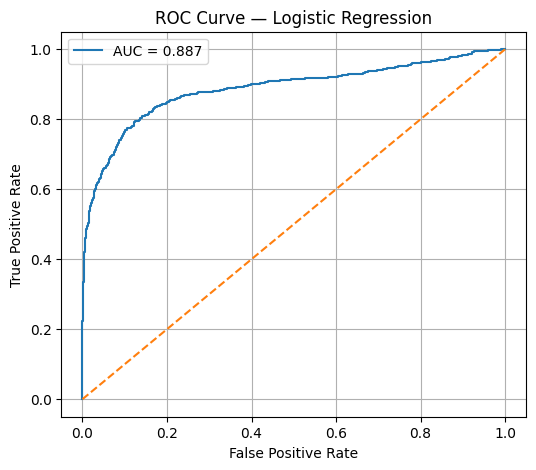

In [7]:
# ============================================
# ROC Curve — Final Logistic Regression
# ============================================

fpr, tpr, _ = roc_curve(y_test, y_prob_best)
auc_lr = roc_auc_score(y_test, y_prob_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_lr:.3f}')
plt.plot([0,1], [0,1], '--')
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


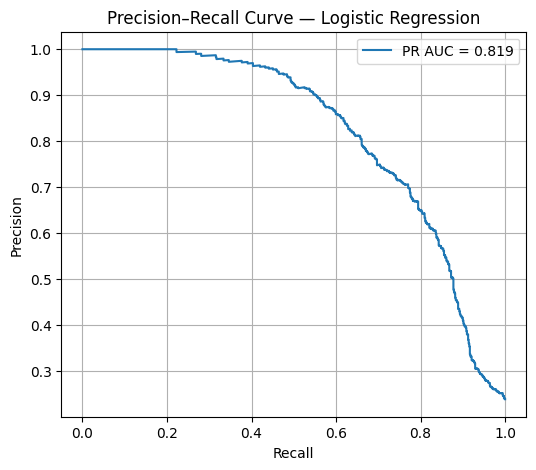

In [8]:
# ============================================
# Precision-Recall Curve — Logistic Regression
# ============================================
from sklearn.metrics import precision_recall_curve, auc
prec, rec, _ = precision_recall_curve(y_test, y_prob_best)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.3f}')
plt.title("Precision–Recall Curve — Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
# ============================================
# SAVE FINAL LOGISTIC REGRESSION MODEL
# ============================================

import joblib

final_log_reg_model = best_lr   # ← correct final model
joblib.dump(final_log_reg_model, "../models/log_reg.pkl")

print("Saved Logistic Regression model as log_reg.pkl")


Saved Logistic Regression model as log_reg.pkl
